# Считывание, фильтрация, предобработка

In [16]:
from PIL import Image
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import sobel
import cv2

## PIL -Считывание рисунков

### Считывание

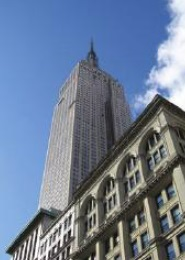

In [9]:
img = Image.open('pics/pic.jpg')
display(img)

Считать в черно-белом виде

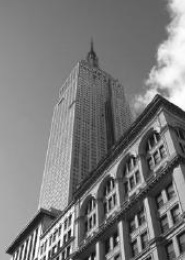

In [10]:
img = Image.open('pics/pic.jpg').convert('L')
display(img)

Считывание множества файлов и сохранение

In [11]:
import os

filelist = ['pics/pic.jpg']
for infile in filelist:
    outfile = os.path.splitext(infile)[0] + '.jpg'
    if infile != outfile:
        try:
            Image.open(infile).save(outfile)
        except IOError:
            print('unable to convert ', infile)

Получить список рисунков

In [12]:
def get_imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

### Создание миниатюр

In [17]:
img = Image.open('pics/pic.jpg')
img.thumbnail((64, 64))

### Обрезка и вставка областей

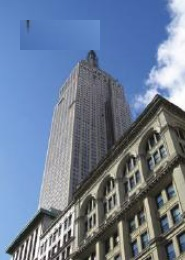

In [18]:
img = Image.open('pics/pic.jpg')
box = (20, 20, 100, 50)
region = img.crop(box)
region = region.transpose(Image.ROTATE_180)
img.paste(region, box)
display(img)

### Изменение размера и поворот

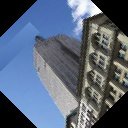

In [20]:
out = img.resize((128, 128))
out = out.rotate(45)
display(out)

## Визуализация Matplotlib

### Визуализация

In [21]:
import matplotlib.pyplot as plt

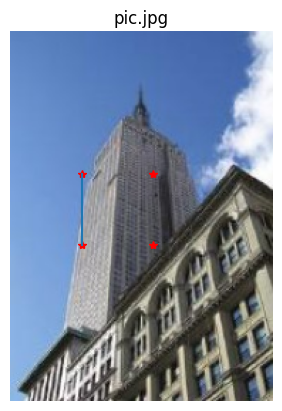

In [23]:
img = Image.open('pics/pic.jpg')
plt.imshow(img)

x = [50, 50, 100, 100]
y = [100, 150, 100, 150]

plt.plot(x, y, 'r*')
plt.plot(x[:2], y[:2])
plt.title('pics/pic.jpg')
plt.axis('off')
plt.show()


### Изолинии и гистограммы

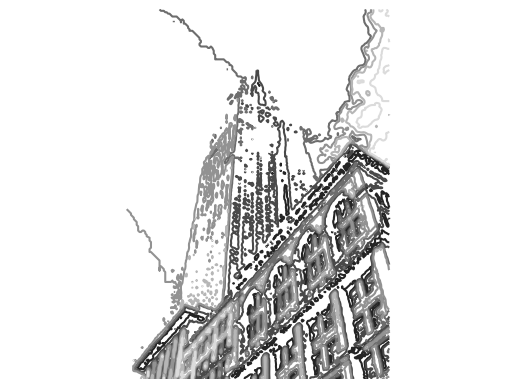

In [24]:
img = np.asarray(Image.open('pics/pic.jpg').convert('L'))
plt.figure()
plt.gray()
plt.contour(img, origin='image')
plt.axis('equal')
plt.axis('off')
plt.show()

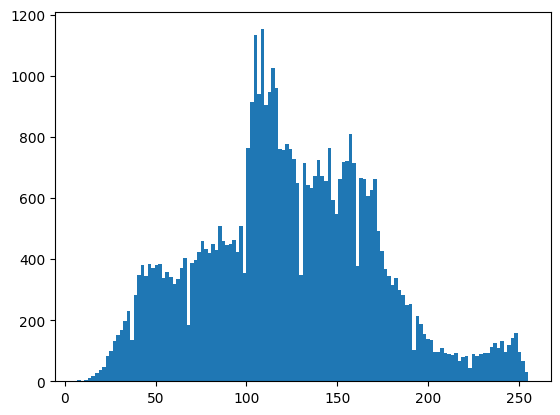

In [25]:
plt.hist(img.flatten(), 128)
plt.show()

### Интерактивное аннотирование

In [ ]:
from matplotlib.pyplot import ginput

img = Image.open('pics/pic.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
x = ginput(3)
print('Clicked coordinates ', x)

## Numpy - преобразование

In [29]:
img = np.array(Image.open('pics/pic.jpg'))
print(img.shape, type(img))

img = np.array(Image.open('pics/pic.jpg').convert('L'), dtype='f')
print(img.shape, type(img))

(260, 185, 3) <class 'numpy.ndarray'>
(260, 185) <class 'numpy.ndarray'>


### Преобразование яркости

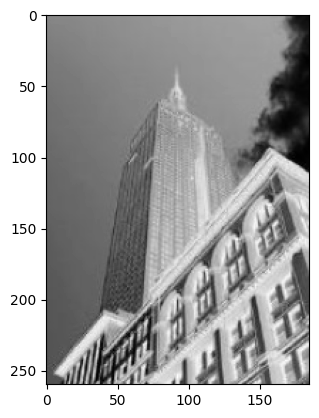

In [30]:
# Инвертирование изображения
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img = 255 - img
plt.imshow(img)

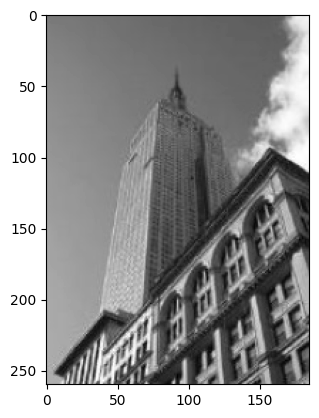

In [31]:
# яркость от 100 до 200
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img = (100.0/255) * img +100
plt.imshow(img)

### PIL from numpy

In [33]:
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img_pil = Image.fromarray(np.uint8(img))

### Выравнивание гистограммы

In [15]:
"""
Выравнивание гистрограммы.

Когда применять: когда все пикселм похожи друг на друга и сложно визуально понять, что находится на изображении.

Функция распределения в таком случае очень неравномерна.
Задача состоит в том, чтобы сделать функцию распределения (cdf) равномерной, превратив ее в линейную.
Функция распределения имеет вид:
cdf(x) = h(0) + h(1) + h(2) + ... + h(x), где 0, 1, 2, .., x - пиксели изображения от 0 до 255.

Формула:
f(x) = round( 255 * (cdf(x) - cdf_min) / (кол-во_пикселей_в_изображений - 1) )
cdf_min - такое значение cdf(x), что cdf(x) != 0
"""

def histeq(img, n_bins=256):
    imhist, bins = np.histogram(img.flatten(), n_bins)
    cdf = imhist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    img2 = np.interp(img.flatten(), bins[:-1], cdf)
    return img2.reshape(img.shape), cdf

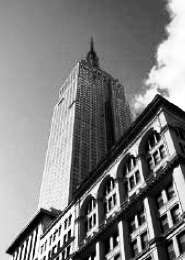

In [25]:
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img2, cdf = histeq(img)
display(Image.fromarray(np.uint8(img2)))

### Усреднение изображений

In [ ]:
def compute_average(imlist):
    average_img = np.array(Image.open(imlist[0]), 'f')
    skipped = 0
    for imname in imlist[1:]:
        try:
            average_img += np.array(Image.open(imname))
        except:
            print('Skipped image ', imname)
            skipped += 1
        average_img /= (len(imlist) - skipped)
    return np.array(average_img, np.uint8)

### PCA

In [17]:
def pca(X):
    """    Principal Component Analysis
        input: X, matrix with training data stored as flattened arrays in rows
        return: projection matrix (with important dimensions first), variance and mean.
    """
    
    # get dimensions
    num_data,dim = X.shape
    
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim>num_data:
        # PCA - compact trick used
        M = np.dot(X,X.T) # covariance matrix
        e,EV = np.linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = np.dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = np.sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = np.linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
    
    # return the projection matrix, the variance and the mean
    return V,S,mean_X

## SciPy

### Размытие изображений

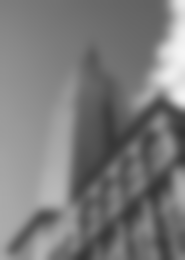

In [23]:
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img = gaussian_filter(img, 5)
display(Image.fromarray(np.uint8(img)))

### Производные изображения

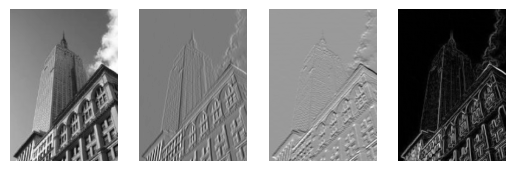

In [39]:
from scipy.ndimage import sobel

img = np.array(Image.open('pics/pic.jpg').convert('L'))

fig, axs = plt.subplots(1, 4)
plt.gray()
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img)

# Операторы Собеля
imx = np.zeros(img.shape)
sobel(img, 1, imx)
axs[1].imshow(imx)

imy = np.zeros(img.shape)
sobel(img, 0, imy)
axs[2].imshow(imy)

magnitude = np.sqrt(imx**2 + imy**2)
axs[3].imshow(magnitude)

С использованием фильра Гаусса

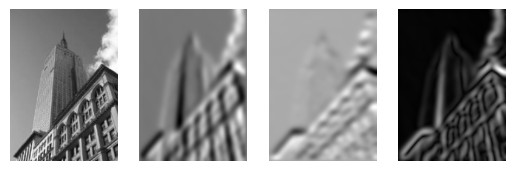

In [41]:
sigma = 5
imx = np.zeros(img.shape)
gaussian_filter(img, (sigma, sigma), (0, 1), imx)

imy = np.zeros(img.shape)
gaussian_filter(img, (sigma, sigma), (1, 0), imy)

magnitude = np.sqrt(imx**2 + imy**2)

fig, axs = plt.subplots(1, 4)
plt.gray()
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img)
axs[1].imshow(imx)
axs[2].imshow(imy)
axs[3].imshow(magnitude)

## OpenCV

### Считывание

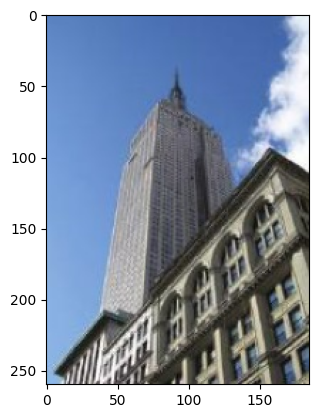

In [19]:
img = cv2.imread('pics/pic.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Преобразование в ЧБ

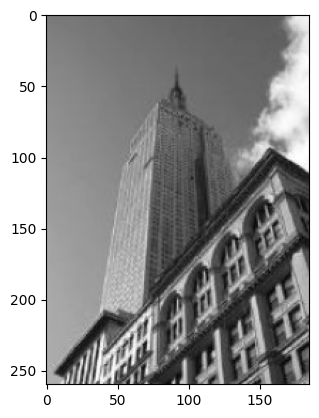

In [21]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

### Считывание видео

In [ ]:
videoCapture = cv2.VideoCapture('MyInputVid.avi')
fps = videoCapture.get(cv2.CAP_PROP_FPS)
size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
videoWriter = cv2.VideoWriter('MyOutputVid.avi', cv2.VideoWriter_fourcc('I','4','2','0'), fps, size)
success, frame = videoCapture.read()
while success: # Loop until there are no more frames.
    videoWriter.write(frame)
    success, frame = videoCapture.read()

### Геометрические фигуры

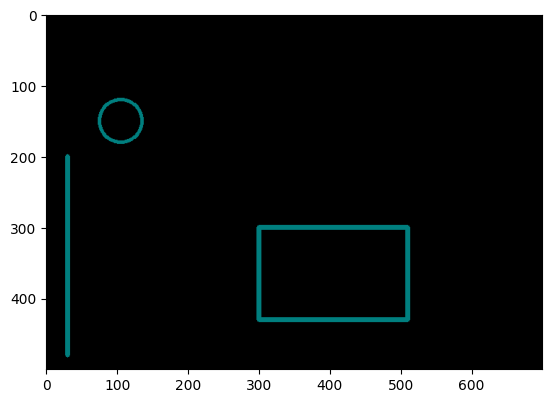

In [22]:
blank_img = np.zeros(shape=(500,700,3),dtype=np.int8)
blank_img=cv2.line(blank_img,pt1=(30,200),pt2=(30,480),color=(0,158,255),thickness=5)
blank_img=cv2.circle(img=blank_img, center=(105,150), radius=30, color=(0,158,255), thickness=3)
cv2.rectangle(blank_img,pt1=(300,300),pt2=(510,430),color=(0,158,255),thickness=5 )
plt.imshow(blank_img)

### Вырезать, изменить размер и вставить

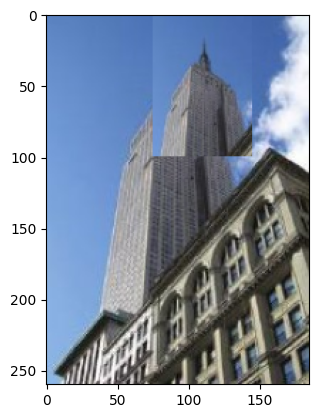

In [24]:
img2 = img[15:145, 40:140]
img2 = cv2.resize(img2, (70, 100))
img3 = img.copy()
img3[0:100, 75:145] = img2
plt.imshow(img3)

### Поворот

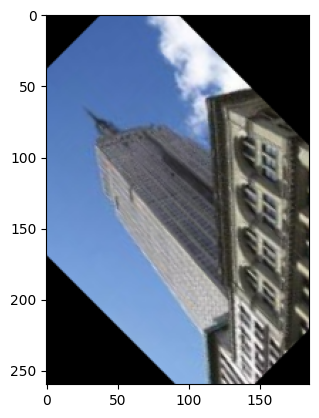

In [26]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

img2 = rotate_image(img, 45)
plt.imshow(img2)

### Изолинии

In [31]:
imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgray, contours, -1, (0, 255, 0), 3)
cv2.imshow('Contours', imgray) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

### Гистограмма

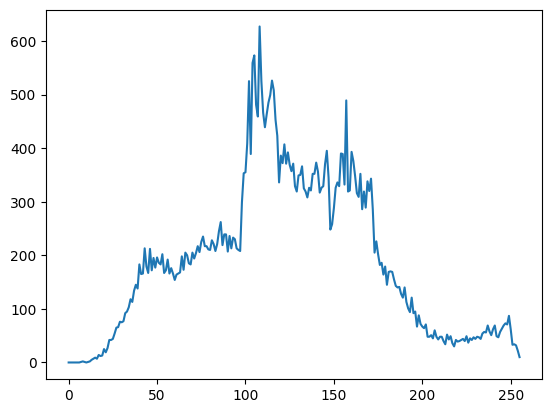

In [32]:
imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hist = cv2.calcHist([imgray], [0], None, [256], [0, 256])
plt.plot(hist)

### Нормализация гистограммы

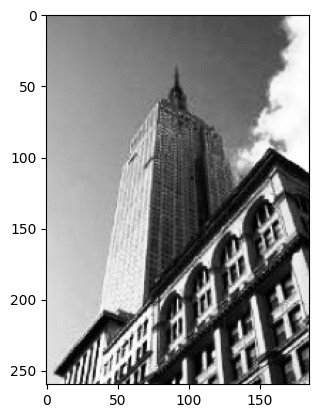

In [33]:
imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
dst = cv2.equalizeHist(imgray)
plt.imshow(dst)

### Выравнивание цветной гистограммы (повышение конрастности)

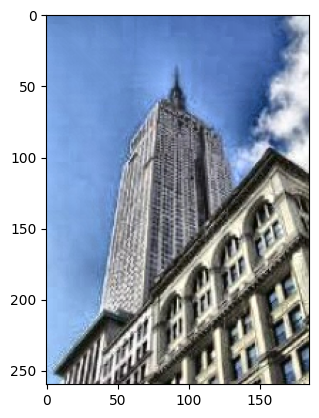

In [43]:
clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
l, a, b = cv2.split(lab)  # split on 3 different channels

l2 = clahe.apply(l)  # apply CLAHE to the L-channel

lab = cv2.merge((l2,a,b))  # merge channels
img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR

plt.imshow(img2)

## Фильтрация

### Размытие

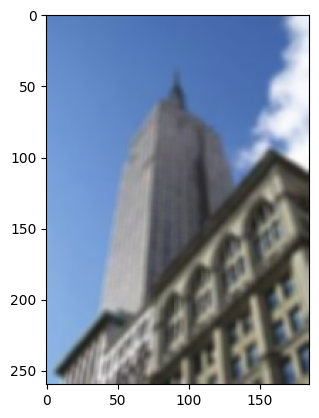

In [35]:
img = cv2.imread('pics/pic.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
blured_img = cv2.blur(img, (5, 5))
plt.imshow(blured_img)

### Фильтр Гаусса (от случайных шумов)

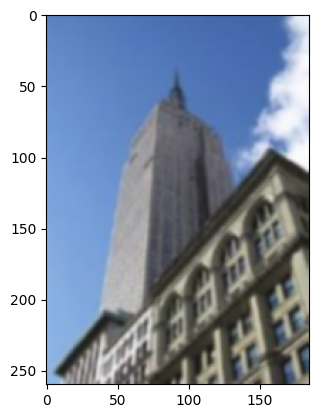

In [36]:
filtered_img = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(filtered_img)

### Медианный фильтр (от царапин)

In [ ]:
median_image  = cv2.medianBlur(img,3)

### Фильтр с заданным ядром свертки

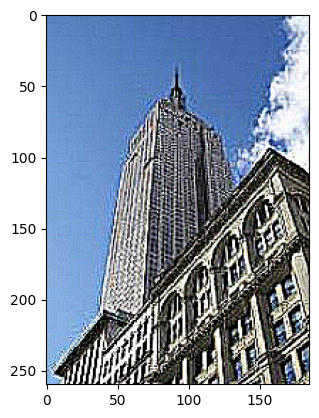

In [38]:
# в данном примере повышаем резкость
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(img, -1, kernel)
plt.imshow(im)

### Фильтр Собеля (выделение контуров)

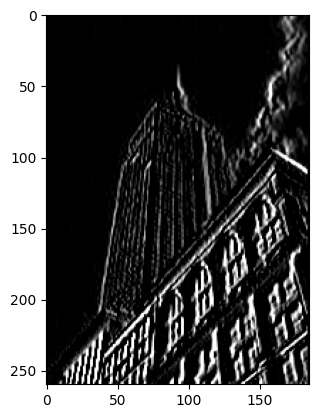

In [41]:
gray_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
im = cv2.filter2D(gray_im, -1, kernel)
plt.imshow(im)

## Морфология

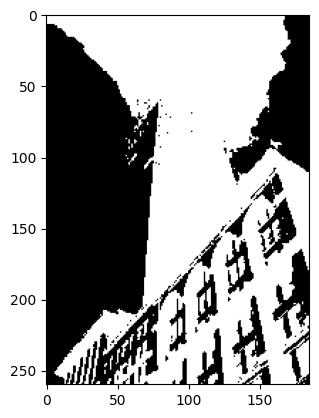

In [53]:
from scipy.ndimage import label

img = np.array(Image.open('pics/pic.jpg').convert('L'))
img = 1 * (img < 128)
plt.imshow(img)

In [54]:
# подсчет объектов
labels, n_ojects = label(img)
print('Количество объектов ', n_ojects)

Количество объектов  93


In [55]:
labels # метки, которым принадлоежат пиксели

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
# Бинарное открытие позволяет убирать перемычки
from scipy.ndimage import binary_opening

img = np.array(Image.open('pics/pic.jpg').convert('L'))
img = 1 * (img < 128)
im_open = binary_opening(img, np.ones((9, 5)), iterations=2)
labels, n_ojects = label(im_open)
print('Количество объектов ', n_ojects)

Количество объектов  10


## Очистка от шумов

In [5]:
def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
        using the numerical procedure presented in Eq. (11) of A. Chambolle
        (2005). Implemented using periodic boundary conditions.
        
        Input: noisy input image (grayscale), initial guess for U, weight of 
        the TV-regularizing term, steplength, tolerance for the stop criterion
        
        Output: denoised and detextured image, texture residual. """
        
    m,n = im.shape #size of noisy image

    # initialize
    U = U_init
    Px = np.zeros((m, n)) #x-component to the dual field
    Py = np.zeros((m, n)) #y-component of the dual field
    error = 1 
    
    while (error > tolerance):
        Uold = U
        
        # gradient of primal variable
        GradUx = np.roll(U,-1,axis=1)-U # x-component of U's gradient
        GradUy = np.roll(U,-1,axis=0)-U # y-component of U's gradient
        
        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx # non-normalized update of x-component (dual)
        PyNew = Py + (tau/tv_weight)*GradUy # non-normalized update of y-component (dual)
        NormNew = np.maximum(1,np.sqrt(PxNew**2+PyNew**2))
        
        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)
        
        # update the primal variable
        RxPx = np.roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = np.roll(Py,1,axis=0) # right y-translation of y-component
        
        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
        U = im + tv_weight*DivP # update of the primal variable
        
        # update of error
        error = np.linalg.norm(U-Uold)/np.sqrt(n*m);
        
    return U,im-U # denoised image and texture residual

In [6]:
#  создание зашумленного изображения

img = np.zeros((500, 500))
img[100:400, 100:400] = 128
img[200:300, 200:300] = 255
img += 30 * np.random.standard_normal((500, 500))

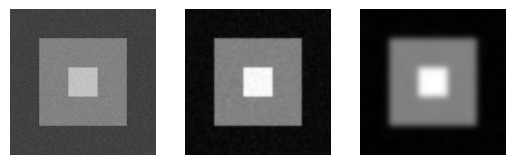

In [8]:
from PCV.tools import preprocessing

U, T = denoise(img, img)
C = gaussian_filter(img, 10)

fig, axs = plt.subplots(1, 3)
plt.gray()
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img)
axs[1].imshow(U)
axs[2].imshow(C)

## Нерезкое маскирование

Размыть изображение и вычесть из исходного, повышает резкость (усиления контраста мелких деталей при неизменном общем контрасте)

In [2]:
def unsharp_masking(img, sigma=10):
    img_blured = gaussian_filter(img, sigma)
    img_filtered = img - img_blured
    return img_filtered 

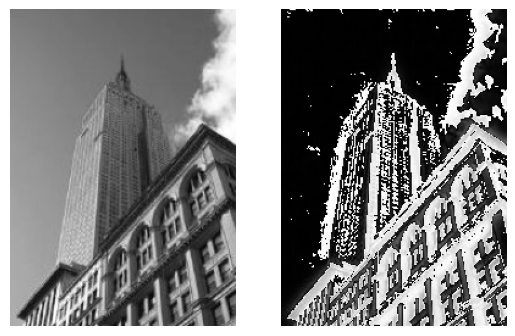

In [9]:
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img_filtered = unsharp_masking(img, 5)

fig, axs = plt.subplots(1, 2)
plt.gray()
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img)
axs[1].imshow(img_filtered)

## Нормировка вычислением изображения-частного

In [10]:
def divide_masking(img, sigma=10):
    img_blured = gaussian_filter(img, sigma)
    img_filtered = img / img_blured
    return img_filtered 

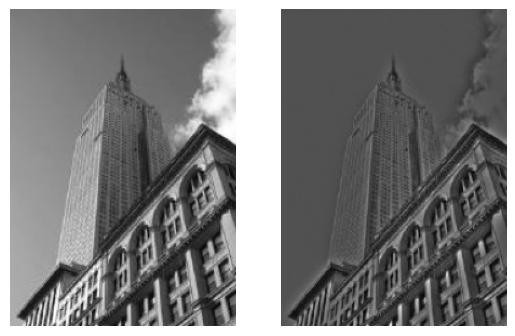

In [11]:
img = np.array(Image.open('pics/pic.jpg').convert('L'))
img_filtered = divide_masking(img, 5)

fig, axs = plt.subplots(1, 2)
plt.gray()
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img)
axs[1].imshow(img_filtered)

## Найти контуры фигуры


### Фильтром Собеля

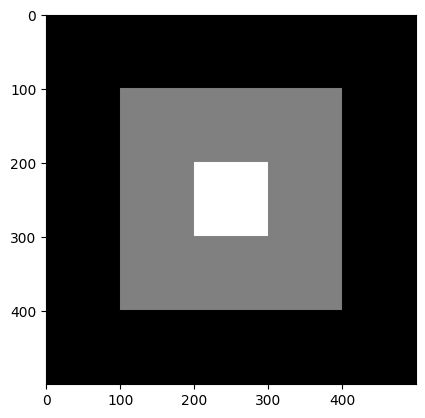

In [47]:
im = np.zeros((500, 500))
im[100:400, 100:400] = 128
im[200:300, 200:300]=255
plt.figure()
plt.gray()
plt.imshow(im)
plt.show()

In [48]:
def edge(X, th):
    imx = np.zeros(X.shape)
    sobel(X, 1, imx)
    imy = np.zeros(X.shape)
    sobel(X, 0, imy)
    ims = np.sqrt(imx**2 + imy**2)
    ims[ims<th]=0
    ims[ims>=th]=1
    ims = np.uint8(ims)
    return ims

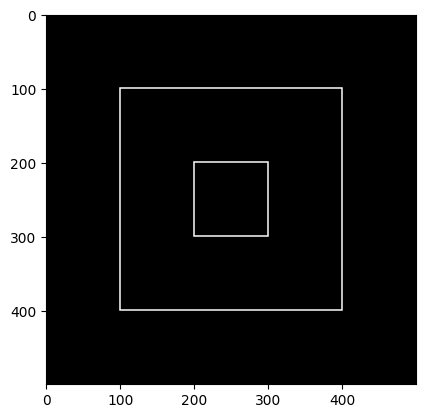

In [49]:
im2 = edge(im, th=0.01)
plt.figure()
plt.gray()
plt.imshow(im2)
plt.show()

### openCV

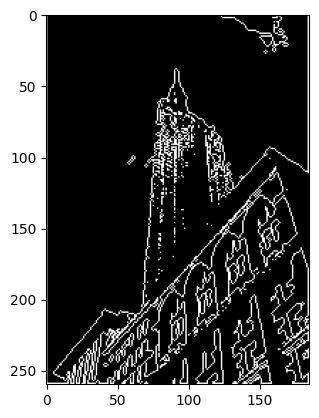

In [42]:
gray_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#зададим порог
thresh = 100
#получим картинку, обрезанную порогом
ret,thresh_img = cv2.threshold(gray_im, thresh, 255, cv2.THRESH_BINARY)

#надем контуры
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#создадим пустую картинку
img_contours = np.zeros(gray_im.shape)

#отобразим контуры
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)

plt.imshow(img_contours)